@Author: Vipin Chaudhari
# Coronavirus Exploratory Data Analysis and Forecasting

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import datetime
from IPython.display import HTML, display
import tabulate
plt.style.use('fivethirtyeight')
%matplotlib inline 

# Load COVID-19 data

In [2]:
confirmed_cases_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

yesterday=datetime.date.today()-datetime.timedelta(days=1)
yesterday=yesterday.strftime("%m-%d-%Y")

daily_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'+yesterday+'.csv')

## Prepare Data

In [3]:
# Function to unpivot the data and cleanup fr common datasets
def melt_df(df):
    df = pd.melt(df, id_vars=["Country/Region","Province/State","Lat","Long"],var_name='Date', value_name="Cases")
    df = df.rename(columns={"Country/Region":"Country","Province/State":"State"}).drop(columns=["State"])
    #df["Date"] = pd.to_datetime(df["Date"])
    df = df.astype({"Country":np.str,"Date":np.datetime64})
    # Lat and Long are same for a country irrespective of state/province. reset_index() used to repeate the group names
    # Instead of reset_index as_index=False in groupby does the same
    # df.groupby(["Country","Date","Lat","Long"], as_index=False)[["Confirmed"]].sum()
    # However asindex removes column from final DF. reset_index keeps it.
    df = df.groupby(["Country","Date","Lat","Long"])[["Cases"]].sum().reset_index()
    return df
    
total_confirmed_df = melt_df(confirmed_cases_df)
total_deaths_df = melt_df(deaths_df)
total_recoveries_df = melt_df(recoveries_df)
#print(total_confirmed_df["Country"].unique())
#print(total_confirmed_df[total_confirmed_df["Country"]=="US"])

# daily data seems to be present in total dataset. Skipping the processing of daily_data for now
#print(total_confirmed_df[total_confirmed_df["Date"]==yesterday])
#print(daily_data[["Country_Region","Lat","Long_","Confirmed","Deaths","Recovered","Active"]].sort_values(by=["Country_Region"]))


In [4]:
# Format the number to display in K or M
def format_number(n):
    if n<1000:
        return '{:,.0f}'.format(n)
    elif n<1000000:
        return '{:,.2f}'.format(n/1000) + 'K'
    else:
        return '{:,.2f}'.format(n/1000000) + 'M'

## Exploratory Data Analysis (EDA)

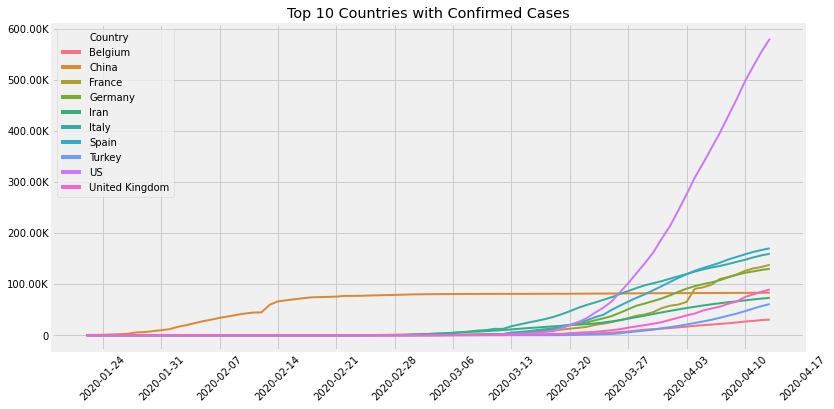

In [5]:
# Current Top 20 countries by confirmed cases
daily_cases_by_country_df=total_confirmed_df.groupby(by=['Date','Country']).sum()['Cases'].reset_index()

top_countries = 10

# Top country list from daily data
top_n_countries_by_confirmed=daily_data.groupby(by=['Country_Region']).sum()['Confirmed'].reset_index().nlargest(top_countries, columns="Confirmed")['Country_Region']
top_n_countries_by_confirmed = list(top_n_countries_by_confirmed)

daily_cases_top_n_df = daily_cases_by_country_df[daily_cases_by_country_df['Country'].isin(top_n_countries_by_confirmed)]

plt.figure(figsize=(12,6))
ax=sns.lineplot(x='Date', y='Cases', hue='Country', data=daily_cases_top_n_df,lw=2)
ax.set_title("Top {} Countries with Confirmed Cases".format(top_countries))

ylabels = [format_number(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels, size=10)
plt.xlabel('')
plt.ylabel('')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=45)
plt.show()

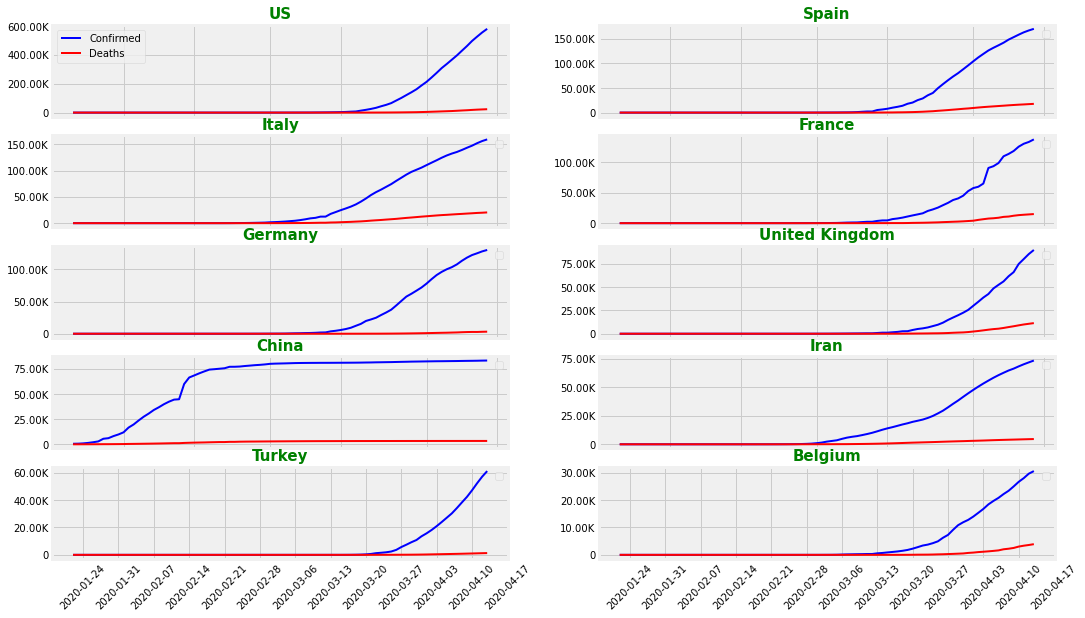

In [6]:
# Top 10 countries with Confirmed cases and Deaths

daily_confirmed_and_deaths_by_country_df= pd.merge(
        left=total_confirmed_df.groupby(by=['Date','Country']).sum()[['Cases']].reset_index(),
        right=total_deaths_df.groupby(by=['Date','Country']).sum()[['Cases']].reset_index(),
        on=['Date','Country']
    )
daily_confirmed_and_deaths_by_country_df.rename(columns={'Cases_x':'Confirmed', 'Cases_y':'Deaths'}, inplace=True)
daily_confirmed_and_deaths_by_country_df = daily_confirmed_and_deaths_by_country_df[daily_confirmed_and_deaths_by_country_df['Country'].isin(top_n_countries_by_confirmed)]

sub_plot_rows=len(top_n_countries_by_confirmed)

fig=plt.figure(figsize=(16,20))
fig.tight_layout()

for idx,c in enumerate(top_n_countries_by_confirmed):
    df=daily_confirmed_and_deaths_by_country_df[daily_confirmed_and_deaths_by_country_df['Country']==c]
    
    ax1=fig.add_subplot(sub_plot_rows,2,idx+1)
    
    ax1=sns.lineplot(x='Date', y='Confirmed', label='Confirmed', color='blue', data=df,lw=2)
    ax1=sns.lineplot(x='Date', y='Deaths', label='Deaths', color='red', data=df,lw=2)
    ax1.set_title(c, fontdict={'fontsize': 15,'fontweight' : 'bold','color' : 'green'})
    
    if idx > 0: ax1.legend("")

    ylabels = [format_number(x) for x in ax1.get_yticks()]
    ax1.set_yticklabels(ylabels, size=10)

    plt.xlabel('')
    plt.ylabel('')

    # Show ticks and labels only on last plots (plot # 9 and 10 in this case)
    if idx+1 >= sub_plot_rows-1:
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
        plt.xticks(rotation=45)
    else:
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.show()

In [7]:
# Current Top 20 countries by confirmed cases
#country_list_df=daily_data.groupby(["Country_Region"])["Confirmed"].sum().reset_index()
#country_list_df=country_list_df.sort_values(by="Confirmed", ascending=False, axis=0)["Country_Region"]
daily_cases_df=daily_data.groupby(by="Country_Region").sum()[['Confirmed', 'Deaths', 'Recovered', 'Active']].reset_index()
daily_cases_df.rename(columns = {'Country_Region':'Country'}, inplace = True)
daily_cases_df=daily_cases_df.sort_values(by="Confirmed", ascending=False)
daily_cases_df['Mortality Rate'] = daily_cases_df["Deaths"]/daily_cases_df["Confirmed"]

daily_cases_df.nlargest(20, columns="Confirmed").style.background_gradient(cmap='rainbow').format({'Confirmed': '{:,}', 'Deaths': '{:,}', 'Recoveries': '{:,}', 'Active': '{:,}', 'Mortality Rate': "{:.2%}"}).hide_index()

Country,Confirmed,Deaths,Recovered,Active,Mortality Rate
US,"580,619","23,529",43482,"615,608",4.05%
Spain,"170,099","17,756",64727,"87,616",10.44%
Italy,"159,516","20,465",35435,"103,616",12.83%
France,"137,875","14,986",28001,"94,888",10.87%
Germany,"130,072","3,194",64300,"62,578",2.46%
United Kingdom,"89,570","11,347",304,"77,919",12.67%
China,"83,213","3,345",78039,"1,829",4.02%
Iran,"73,303","4,585",45983,"22,735",6.25%
Turkey,"61,049","1,296",3957,"55,796",2.12%
Belgium,"30,589","3,903",6707,"19,979",12.76%


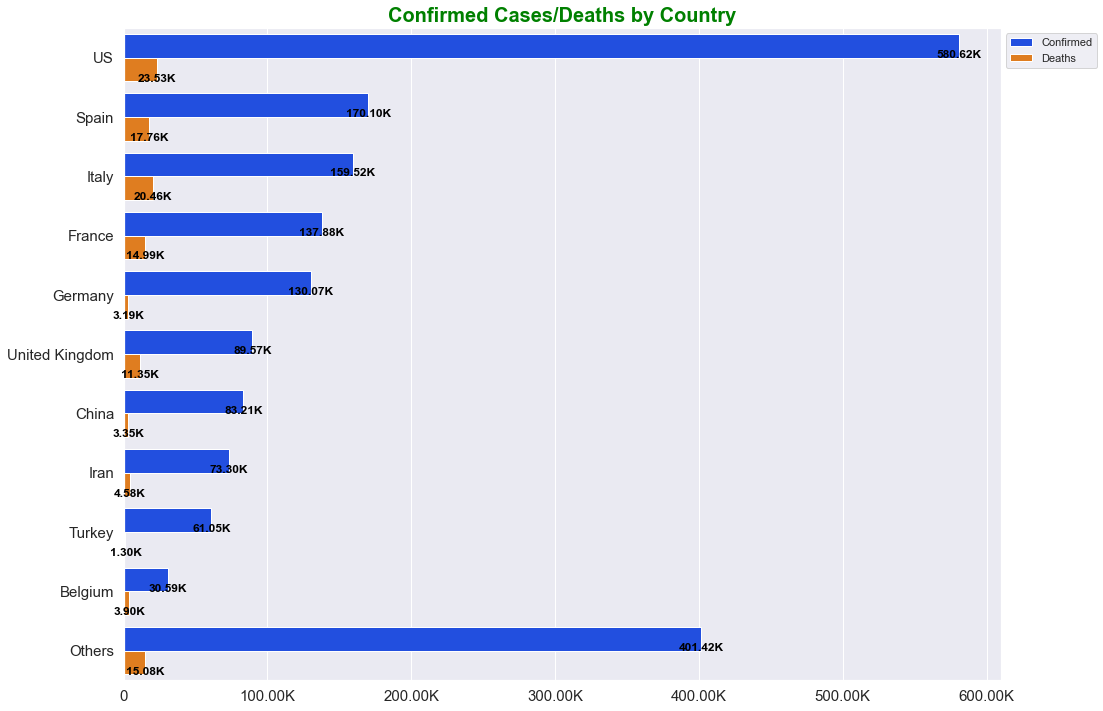

In [8]:
import seaborn as sns

# Get top 10 countries and select Country and Confirmed columns
top_10_countries_df=daily_data[['Country_Region','Confirmed', 'Deaths']] #daily_data.iloc[:10,[0,1]]
top_10_countries_df = top_10_countries_df.rename(columns={"Country_Region":"Country"})
top_10_countries_df = top_10_countries_df.groupby(["Country"])[["Confirmed",'Deaths']].sum().reset_index()
top_10_countries_df = top_10_countries_df.sort_values(by="Confirmed", ascending=False)

other_countries_df=pd.DataFrame({"Country":"Others", "Confirmed":top_10_countries_df.iloc[10:,1].sum(), "Deaths":top_10_countries_df.iloc[10:,2].sum()}, index=[0])

# Explicit index is adeed to avoid ValueError: If using all scalar values, you must pass an index
top_10_countries_df=top_10_countries_df[0:10].append(other_countries_df)
#Move Confirmed and Deaths to row
top_10_countries_df=pd.melt(top_10_countries_df, id_vars=['Country'], var_name='Case_Type', value_name="Cases")

# defaults                                                                                                         
sns.set()
f, ax = plt.subplots(figsize=(14, 12))
palette = sns.color_palette("bright", 4)
g=sns.barplot(data=top_10_countries_df, x="Cases", y="Country", hue='Case_Type', palette= palette)
g.set_title("Confirmed Cases/Deaths by Country", size=20, weight='bold', Color="green")
g.legend(bbox_to_anchor=(1, 1), ncol=1)
#xlabels = ['{:,.2f}'.format(x/1000) + 'K' if x<1000000 else '{:,.0f}'.format(x/1000000) + 'M' for x in g.get_xticks()]
xlabels = [format_number(x) for x in ax.get_xticks()]
g.set_xticklabels(xlabels, size=15)
g.set_yticklabels(ax.get_yticklabels(), size=15)
ax.set_ylabel('')    
ax.set_xlabel('')
# Show bar values on the bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width, p.get_y()+p.get_height()/2. + 0.2, format_number(width), ha="center", size=12, color="black",weight='bold')
plt.show()
#sns.axes_style()

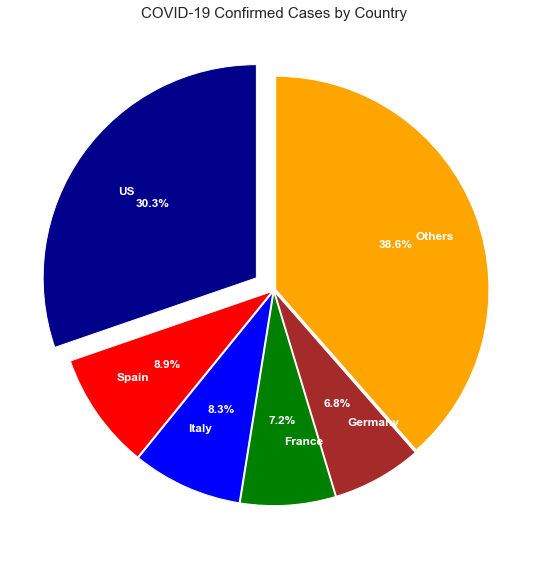

In [9]:
top_5_countries_df=daily_data[['Country_Region','Confirmed']] #daily_data.iloc[:10,[0,1]]
top_5_countries_df = top_5_countries_df.rename(columns={"Country_Region":"Country"})
top_5_countries_df = top_5_countries_df.groupby(["Country"])[["Confirmed"]].sum().reset_index()
top_5_countries_df = top_5_countries_df.sort_values(by="Confirmed", ascending=False)

other_countries_df=pd.DataFrame({"Country":"Others", "Confirmed":top_5_countries_df.iloc[5:,1].sum()}, index=[0])
top_5_countries_df=top_5_countries_df.iloc[0:5].append(other_countries_df)

#colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(top_5_countries_df["Country_Region"].unique()))
colors = ['darkblue', 'red', 'blue', 'green', 'brown', 'orange']
plt.figure(figsize=(8,8))
plt.title('COVID-19 Confirmed Cases by Country', size=15)
explode=(0.1, 0.01, 0.01, 0.01, 0.01, 0.01)
textprops={'fontsize': 12, 'weight':'bold', 'color':'white'}
labels=top_5_countries_df["Country"].unique()

patches, texts, autotexts = plt.pie(top_5_countries_df["Confirmed"], colors=colors,explode=explode,autopct='%1.1f%%',shadow=False,startangle=90,labels=labels,labeldistance=0.7, textprops=textprops)
#[ _.set_fontsize(15) for _ in texts] #texts[0].set_fontsize(4)
#plt.legend(top_5_countries_df["Country_Region"].unique(), loc='best', fontsize=15)
plt.tight_layout()
plt.show()

In [10]:
#daily_data[daily_data["Country_Region"]=="US"]
#total_recoveries_df[(total_recoveries_df["Country"]=="US") & (total_recoveries_df["Date"]==yesterday)]

total_US_cases_df = daily_data[(daily_data["Country_Region"]=="US")]
total_US_cases_df = total_US_cases_df.rename(columns={"Province_State":"State","Long_":"Long"})
total_US_cases_df = total_US_cases_df.groupby(["State"])[["Confirmed","Deaths","Recovered","Active"]].sum().reset_index()
total_US_cases_df=total_US_cases_df.sort_values(by="Confirmed", ascending=False)
daily_US_cases_top25_df = total_US_cases_df.nlargest(25, columns="Confirmed")

US_cases_by_state_df = daily_US_cases_top25_df = pd.DataFrame({ 'US State': daily_US_cases_top25_df["State"],
                            'Confirmed': daily_US_cases_top25_df["Confirmed"],
                            'Deaths': daily_US_cases_top25_df["Deaths"],
                            'Recoveries' : daily_US_cases_top25_df["Recovered"],
                            'Active' : daily_US_cases_top25_df["Active"],
                            'Mortality Rate': daily_US_cases_top25_df["Deaths"]/daily_US_cases_top25_df["Confirmed"]})

US_cases_by_state_df.style.background_gradient(cmap='viridis').format({'Confirmed': '{:,}', 'Deaths': '{:,}', 'Recoveries': '{:,}', 'Active': '{:,}', 'Mortality Rate': "{:.2%}"}).hide_index()

US State,Confirmed,Deaths,Recoveries,Active,Mortality Rate
New York,"195,749","10,058",0,"185,691",5.14%
New Jersey,"64,584","2,443",0,"62,141",3.78%
Massachusetts,"26,867",844,0,"26,023",3.14%
Michigan,"25,635","1,602",0,"24,033",6.25%
Pennsylvania,"24,292",589,0,"23,703",2.42%
California,"23,931",715,0,"23,216",2.99%
Illinois,"22,025",798,0,"21,227",3.62%
Florida,"21,019",499,0,"122,520",2.37%
Louisiana,"21,016",884,0,"20,132",4.21%
Texas,"14,275",305,0,"13,970",2.14%


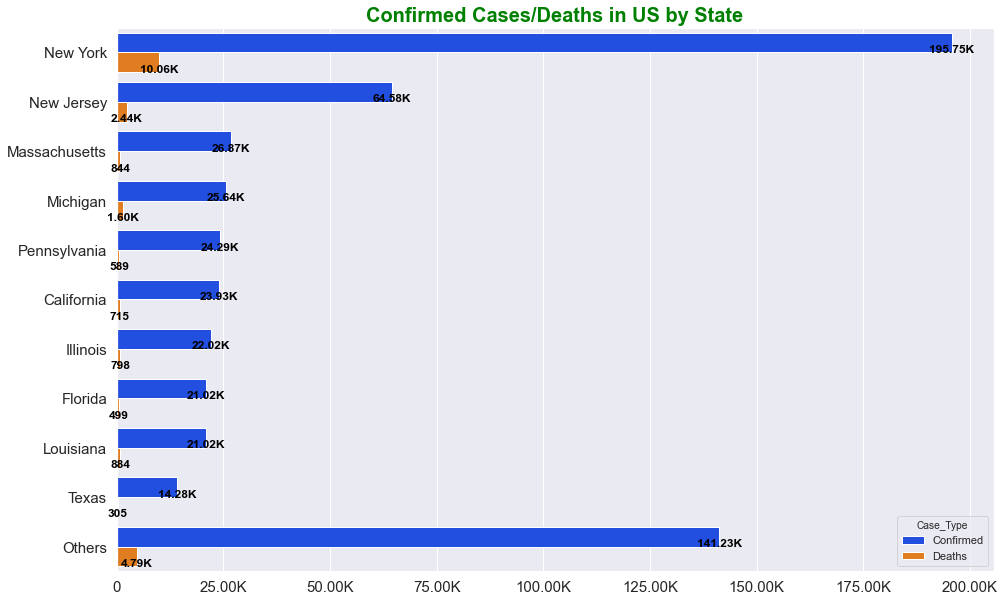

In [11]:
import seaborn as sns

total_US_cases_df = daily_data[(daily_data["Country_Region"]=="US")]
total_US_cases_df = total_US_cases_df.rename(columns={"Province_State":"State","Long_":"Long"})
total_US_cases_df = total_US_cases_df.groupby(["State"])[["Confirmed",'Deaths']].sum().reset_index()
total_US_cases_df= total_US_cases_df.sort_values(by="Confirmed", ascending=False)
daily_US_cases_top10_df = total_US_cases_df.nlargest(10, columns="Confirmed")

other_US_states_df=pd.DataFrame({"State":"Others", "Confirmed":total_US_cases_df.iloc[10:,1].sum(), "Deaths":total_US_cases_df.iloc[10:,2].sum()}, index=[0])
daily_US_cases_top10_df=daily_US_cases_top10_df.append(other_US_states_df)
#Move Confirmed and Deaths to row
daily_US_cases_top10_df=pd.melt(daily_US_cases_top10_df, id_vars=['State'], var_name='Case_Type', value_name="Cases")

# defaults                                                                                                         
sns.set()
f, ax = plt.subplots(figsize=(14, 10))
palette = sns.color_palette("bright", 4)
g=sns.barplot(data=daily_US_cases_top10_df, x="Cases", y="State", hue='Case_Type',palette= palette)
g.set_title("Confirmed Cases/Deaths in US by State", size=20, weight='bold',Color="green")
#g.legend(bbox_to_anchor=(1, 1), ncol=1)
xlabels = [format_number(x) for x in ax.get_xticks()]
g.set_xticklabels(xlabels, size=15)
g.set_yticklabels(ax.get_yticklabels(), size=15)
ax.set_ylabel('')
ax.set_xlabel('')
# Show bar values on the bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width, p.get_y()+p.get_height()/2. + 0.2, format_number(width), ha="center", size=12, color="black",weight='bold')
plt.show()
#sns.axes_style()

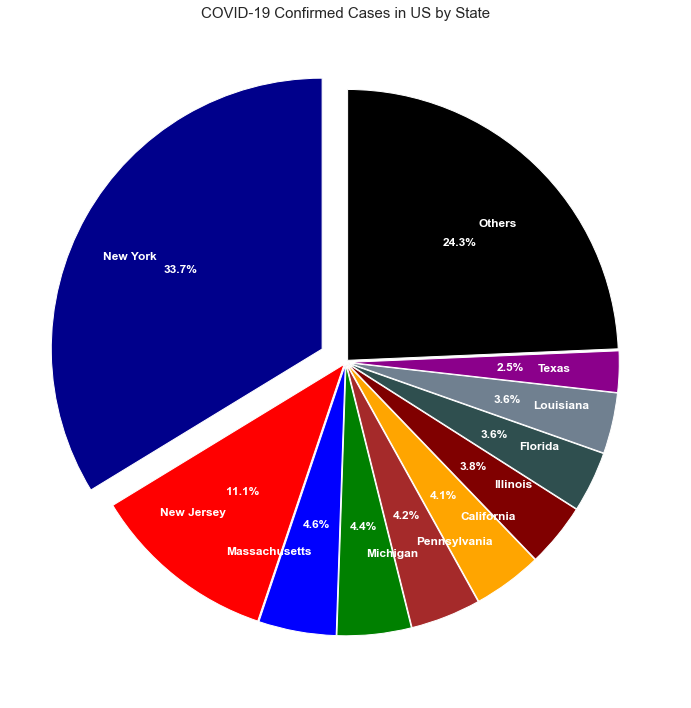

In [12]:
total_US_cases_df = daily_data[(daily_data["Country_Region"]=="US")]
total_US_cases_df = total_US_cases_df.rename(columns={"Province_State":"State","Long_":"Long"})
total_US_cases_df = total_US_cases_df.groupby(["State"])[["Confirmed"]].sum().reset_index()
total_US_cases_df= total_US_cases_df.sort_values(by="Confirmed", ascending=False)
daily_US_cases_top10_df = total_US_cases_df.nlargest(10, columns="Confirmed")

other_US_states_df=pd.DataFrame({"State":"Others", "Confirmed":total_US_cases_df.iloc[10:,1].sum()}, index=[0])
daily_US_cases_top10_df=daily_US_cases_top10_df.append(other_US_states_df)

colors = ['darkblue', 'red', 'blue', 'green', 'brown', 'orange','maroon','darkslategrey','slategrey','darkmagenta','black']
plt.figure(figsize=(10,10))
plt.title('COVID-19 Confirmed Cases in US by State', size=15)
explode=(0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
textprops={'fontsize': 12, 'weight':'bold', 'color':'white'}
labels=daily_US_cases_top10_df["State"].unique()

patches, texts, autotexts = plt.pie(daily_US_cases_top10_df["Confirmed"], colors=colors,explode=explode,autopct='%1.1f%%',shadow=False,startangle=90,labels=labels,labeldistance=0.7, textprops=textprops)
plt.tight_layout()
plt.show()

## 7 Day rolling average analysis
Till date cases are growing more than previous 7 day average. When 7 day average falls above confirmmed cases, that will be an indication of flattening the curve!!!!

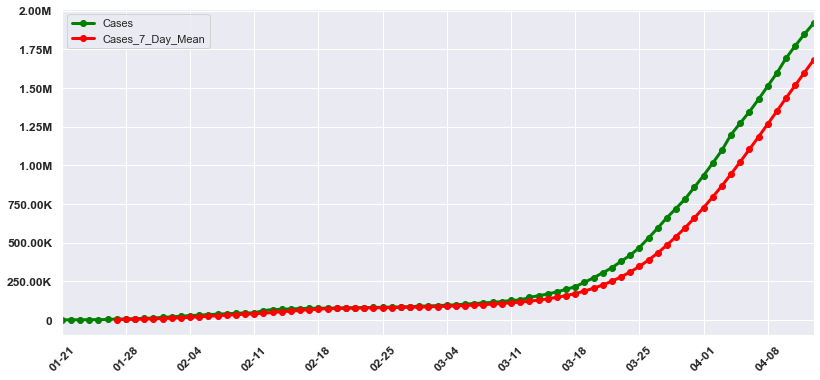

In [13]:
confirmed_cases_avg_df = total_confirmed_df.groupby(by='Date')['Cases'].sum().reset_index()
confirmed_cases_avg_df['Cases_7_Day_Mean'] = confirmed_cases_avg_df['Cases'].rolling(window=7).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

confirmed_cases_avg_df[['Date','Cases','Cases_7_Day_Mean']].plot(x='Date', kind='line', lw=3, color=['green','red'], fontsize=10, ax=ax1, marker='o', markersize=6)
ylabels = [format_number(x) for x in ax1.get_yticks()]
ax1.set_yticklabels(ylabels, size=12, weight='bold')

ax1.set_xticklabels(confirmed_cases_avg_df['Date'], rotation=45, size=12, weight='bold')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax1.set_xlabel('')

plt.show()

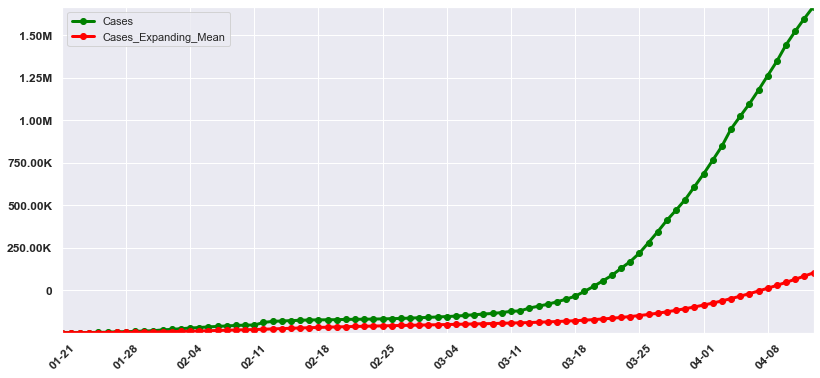

In [14]:
# expanding mean - mean of all points taken bofore and including the current datapoint
confirmed_cases_avg_df['Cases_Expanding_Mean'] = confirmed_cases_avg_df['Cases'].expanding().mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

confirmed_cases_avg_df[['Date','Cases','Cases_Expanding_Mean']].plot(x='Date', kind='line', lw=3, color=['green','red'], fontsize=10, ax=ax1, marker='o', markersize=6)
ylabels = [format_number(x) for x in ax1.get_yticks()]
ax1.set_yticklabels(ylabels, size=12, weight='bold')

ax1.set_xticklabels(confirmed_cases_avg_df['Date'], rotation=45, size=12, weight='bold')
ax1.autoscale(axis='both', tight=True)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax1.set_xlabel('');

# Forecasting

Data Prep

In [15]:
def is_date(date_text):
    try:
        datetime.datetime.strptime(date_text, "%m/%d/%y")
        return True
    except ValueError:
        return False

In [16]:
dates = list(confirmed_cases_df.keys())
# Collect all dates. Get rid of headers
dates = [datetime.datetime.strptime(d, "%m/%d/%y").strftime("%m-%d-%Y") for d in dates if is_date(d)]

latest_date = pd.to_datetime(dates, errors="coerce").max()
forecast_days = 15
forecast_end_date = latest_date + datetime.timedelta(days=forecast_days)

forecast_dates=[]
dt=latest_date+ datetime.timedelta(days=1)

while dt <= forecast_end_date:
    forecast_dates.append(dt.strftime('%m-%d-%Y'))
    dt += datetime.timedelta(days=1)


# Create an array of numbers for each day
days_arr = np.array([i for i in range(len(dates))]).reshape(-1, 1)

n=len(days_arr)
# Create an array of numbers for each day including forecast period
forecast_days_arr = np.array([i+n for i in range(len(forecast_dates))]).reshape(-1, 1)

### Train Test Split (15%)

In [17]:
confirmed_cases_arr = np.array(total_confirmed_df.groupby("Date")["Cases"].sum().reset_index()["Cases"]).reshape(-1,1)

# Split the data between training and testing
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_arr, confirmed_cases_arr, test_size=0.15, shuffle=False)

## Forecasting: Support Vector Regressor

In [18]:
# gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
# epsilon: It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
# degree: Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed.flatten())
svm_pred = svm_confirmed.predict(forecast_days_arr)

5 degree polynomial gives better results with 98% R-Squared

MAE: 257476.19129728648
MSE: 68082809114.11962
RMSE: 260926.82712614973
R Squared:  0.9769170097536536


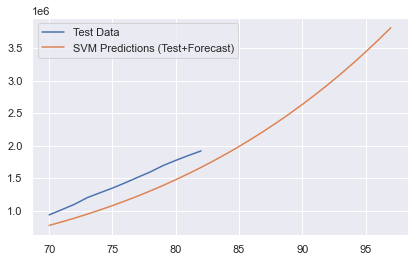

In [19]:
# Plotting test and forecast data

svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(X_test_confirmed,y_test_confirmed)
plt.plot(np.append(X_test_confirmed, forecast_days_arr),np.append(svm_test_pred,svm_pred))
plt.legend(['Test Data', 'SVM Predictions (Test+Forecast)'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))
print('RMSE:', np.sqrt(mean_squared_error(svm_test_pred, y_test_confirmed)))
print('R Squared: ', explained_variance_score(svm_test_pred, y_test_confirmed))

Second plot shows better normal distribution of differences indicating model performed better

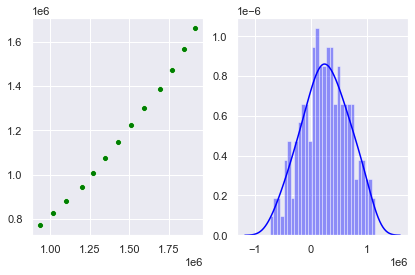

In [20]:
import seaborn as sns
f, axes = plt.subplots(1, 2)
sns.scatterplot(y_test_confirmed.flatten(),svm_test_pred, color='green', ax=axes[0])
sns.distplot(y_test_confirmed-svm_test_pred,bins=30, color='blue', ax=axes[1]);

## Forecasting: Polynomial Regression

MAE: 189953.83080564672
MSE: 37593701288.71703
RMSE: 193890.95205480073
R Squared:  0.9805143761585176


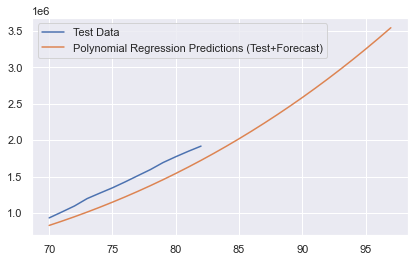

In [21]:
# Project single feature to # of degree polynomial
# Degree 3 works better in this case

polynomial_reg = PolynomialFeatures(degree=3)
poly_X_train_confirmed = polynomial_reg.fit_transform(X_train_confirmed)
poly_X_test_confirmed = polynomial_reg.fit_transform(X_test_confirmed)
poly_forcast = polynomial_reg.fit_transform(forecast_days_arr)

#display(HTML(tabulate.tabulate(X_test_confirmed.T, tablefmt='html')))
#display(HTML(tabulate.tabulate(poly_X_test_confirmed, tablefmt='html',floatfmt=".0f")))

# Use above projected features as polynomial to forecast in linear regression

lm = LinearRegression(normalize=True, fit_intercept=False)
lm.fit(poly_X_train_confirmed, y_train_confirmed)
test_lm_pred = lm.predict(poly_X_test_confirmed)
lm_pred = lm.predict(poly_forcast)

# Plotting test and forecast data
plt.plot(X_test_confirmed,y_test_confirmed)
plt.plot(np.append(X_test_confirmed, forecast_days_arr), np.append(test_lm_pred,lm_pred))
plt.legend(['Test Data', 'Polynomial Regression Predictions (Test+Forecast)'])
print('MAE:', mean_absolute_error(test_lm_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_lm_pred, y_test_confirmed))
print('RMSE:', np.sqrt(mean_squared_error(test_lm_pred, y_test_confirmed)))
print('R Squared: ', explained_variance_score(test_lm_pred, y_test_confirmed))